In [1]:
import pandas as pd
import numpy as np
import xgboost
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
train = pd.read_csv('../data/acc_data/training_large_lag_5.csv', sep = '\t')#,header = None)
test = pd.read_csv('../data/acc_data/validation_large_lag_5.csv', sep = '\t')#,header = None)

In [3]:
train.head()

,id,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,...,vy_lag_1,vy_lag_2,vy_lag_3,vy_lag_4,vy_lag_5,vz_lag_1,vz_lag_2,vz_lag_3,vz_lag_4,vz_lag_5
0,0,0.004759,5.381700,0.018847,25.272266,-0.063834,-5.852429,-5.317527,0.082767,-2.247178,...,5.306345,5.228192,5.170937,5.089469,5.048233,0.014216,0.011857,0.004388,-0.003711,-0.011478
1,0,0.022305,5.480248,0.018905,25.332757,-0.073657,-6.111881,-5.425455,0.085127,-2.581476,...,5.381700,5.306345,5.228192,5.170937,5.089469,0.018847,0.014216,0.011857,0.004388,-0.003711
2,0,0.022637,5.558247,0.016655,25.385312,-0.081630,-6.354088,-5.511716,0.090870,-2.409903,...,5.480248,5.381700,5.306345,5.228192,5.170937,0.018905,0.018847,0.014216,0.011857,0.004388
3,0,0.031174,5.652034,0.018334,25.495780,-0.077027,-6.604493,-5.614386,0.093267,-2.491468,...,5.558247,5.480248,5.381700,5.306345,5.228192,0.016655,0.018905,0.018847,0.014216,0.011857
4,0,0.027432,5.746208,0.019073,25.596243,-0.072461,-6.842672,-5.717490,0.093339,-2.369821,...,5.652034,5.558247,5.480248,5.381700,5.306345,0.018334,0.016655,0.018905,0.018847,0.014216


In [5]:
X = train.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                 'vx_lag_1','vx_lag_2', 'vx_lag_3', 'vx_lag_4', 'vx_lag_5', 'vy_lag_1', 'vy_lag_2',
                 'vy_lag_3','vy_lag_4', 'vy_lag_5', 'vz_lag_1', 'vz_lag_2', 'vz_lag_3','vz_lag_4', 'vz_lag_5']]
Y_ax = train.loc[:,['ax']].values.ravel() # flatten to 1d array
Y_ay = train.loc[:,['ay']].values.ravel()

# y = Y_ax
X_train_ax, X_test_ax, y_train_ax, y_test_ax = train_test_split(X, Y_ax)
X_train_ay, X_test_ay, y_train_ay, y_test_ay = train_test_split(X, Y_ay)

#### Baseline 

In [6]:
model_XGB = make_pipeline(StandardScaler(), xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                                            n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85))
print(' Extreme Gradient Boosting score for ax is: ' ,-np.mean(cross_val_score(model_XGB,X_train_ax,y_train_ax, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')

 Extreme Gradient Boosting score for ax is:  0.075986171928549 



In [7]:
model_XGB = make_pipeline(StandardScaler(), xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                                            n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85))
print(' Extreme Gradient Boosting score for ay is: ' ,-np.mean(cross_val_score(model_XGB,X_train_ay,y_train_ay, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')

 Extreme Gradient Boosting score for ay is:  0.07418674519424065 



#### Improved model

In [8]:
train.describe()

,id,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,...,vy_lag_1,vy_lag_2,vy_lag_3,vy_lag_4,vy_lag_5,vz_lag_1,vz_lag_2,vz_lag_3,vz_lag_4,vz_lag_5
count,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,1.516650e+05,1.516650e+05,151665.000000,...,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000,151665.000000
mean,391.462058,-0.043072,0.304529,0.004331,15.910924,-0.017896,-0.146946,-3.794968e-01,1.123299e-02,-0.006459,...,0.303942,0.303339,0.302733,0.302117,0.301495,0.004243,0.004153,0.004066,0.003988,0.003919
std,226.314029,6.839385,6.780010,0.250827,20.474913,0.638569,7.409735,4.866135e+00,1.904636e-01,3.856549,...,6.779262,6.778530,6.777811,6.777108,6.776418,0.250850,0.250852,0.250841,0.250835,0.250842
min,0.000000,-29.725990,-28.805597,-1.870755,0.000000,-2.829590,-36.599137,-4.439295e+01,-2.205683e+00,-229.525634,...,-28.805597,-28.805597,-28.797590,-28.775511,-28.765280,-1.870755,-1.870755,-1.870755,-1.870755,-1.870755
25%,195.000000,-1.071985,-1.098212,-0.036435,0.000000,0.000000,-0.001517,0.000000e+00,0.000000e+00,0.000000,...,-1.101246,-1.104296,-1.106323,-1.108733,-1.111418,-0.036474,-0.036511,-0.036527,-0.036527,-0.036515
50%,391.000000,0.000000,0.000000,0.000000,8.770812,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,587.000000,1.487546,1.444024,0.039479,27.996002,0.056486,0.000000,2.977394e-13,7.095193e-14,0.000000,...,1.443252,1.442176,1.441070,1.439708,1.437258,0.039378,0.039323,0.039301,0.039301,0.039272
max,783.000000,29.348547,29.198553,2.021150,82.337646,2.869635,62.529255,3.654719e+01,3.251867e+00,247.073979,...,29.198553,29.198553,29.274393,29.274393,29.274889,2.021150,2.021150,2.021150,2.021150,2.021150


We can see a small increase in accuracy, so we will keep it. Now we will try three different models and see how they work, this models are:
* XGboost
* Gradient Boosting Regressor
* LightGBM Regressor

In [9]:
def boosting_models(X_train,y_train):
    
    categorical = X_train.dtypes == object
    
    model_GBC = make_pipeline(RobustScaler(), GradientBoostingRegressor(alpha = 0.85, n_estimators = 1000, max_depth = 3))
    model_LGB = make_pipeline(RobustScaler(), LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=800))
    model_XGB = make_pipeline(RobustScaler(), xgboost.XGBRegressor(gamma=0.05, learning_rate=0.05, max_depth=3, n_estimators=2500, reg_alpha=0.5, reg_lambda=0.85))

    print('Gradient Boosting score is: ' , -np.mean(cross_val_score(model_GBC,X_train,y_train, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')
    print('Light Gradient Boosting score is: ' , -np.mean(cross_val_score(model_LGB,X_train,y_train, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')
    print(' Extreme Gradient Boosting score is: ' , -np.mean(cross_val_score(model_XGB,X_train,y_train, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')
    
    
    return model_GBC, model_LGB,model_XGB

##### Ax

In [10]:
model_GBC, model_LGB, model_XGB = boosting_models(X_train_ax,y_train_ax)

Gradient Boosting score is:  0.0829425438607513 

Light Gradient Boosting score is:  0.11313790575479565 

 Extreme Gradient Boosting score is:  0.07609687646199806 



##### Ay

In [11]:
model_GBC_ay, model_LGB_ay, model_XGB_ay = boosting_models(X_train_ay,y_train_ay)

Gradient Boosting score is:  0.07954757651412839 

Light Gradient Boosting score is:  0.10899122878490264 

 Extreme Gradient Boosting score is:  0.07425409210534299 



In [12]:
def stacking_model(X_train,y_train):
    
    lasso = Lasso(alpha = 1e-3)
    GBC = GradientBoostingRegressor(alpha = 0.85,n_estimators = 1000,max_depth = 3)
    LGB = LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=800)
    XGB = xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3, n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

    categorical = X_train.dtypes == object
    model_SR = make_pipeline(RobustScaler(), StackingRegressor(regressors=[LGB,lasso,XGB], meta_regressor=lasso))

    scores = cross_val_score(model_SR, X_train, y_train, scoring='neg_median_absolute_error',cv=5, n_jobs = -1)
    print("Stacking Regressor score: ", -scores.mean(), ' std: ', scores.std())
    
    return model_SR

In [13]:
model_SR = stacking_model(X_train_ax,y_train_ax)

Stacking Regressor score:  0.05706549608512834  std:  0.0008820975909242986


In [14]:
model_SR_ay = stacking_model(X_train_ax,y_train_ax)

Stacking Regressor score:  0.05706549608512834  std:  0.0008820975909242986


#### Model validation

In [15]:
test.head(2)

,id,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,...,vy_lag_1,vy_lag_2,vy_lag_3,vy_lag_4,vy_lag_5,vz_lag_1,vz_lag_2,vz_lag_3,vz_lag_4,vz_lag_5
0,0,0.002710,-0.005262,-0.001673,8.369227,-0.974081,-0.002021,0.005210,0.001584,-0.001193,...,0.002781,-0.007835,-0.003755,-0.002571,-0.004242,-0.000141,0.000287,-0.002811,-0.001783,-0.003525
1,0,0.000473,-0.003617,0.000159,8.369625,-0.974627,0.002320,0.003409,-0.000521,0.043193,...,-0.005262,0.002781,-0.007835,-0.003755,-0.002571,-0.001673,-0.000141,0.000287,-0.002811,-0.001783


In [16]:
X_val = test.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                 'vx_lag_1','vx_lag_2', 'vx_lag_3', 'vx_lag_4', 'vx_lag_5', 'vy_lag_1', 'vy_lag_2',
                 'vy_lag_3','vy_lag_4', 'vy_lag_5', 'vz_lag_1', 'vz_lag_2', 'vz_lag_3','vz_lag_4', 'vz_lag_5']]
y_val_ax = test.loc[:, ['ax']].values.ravel()
y_val_ay = test.loc[:, ['ay']].values.ravel()

In [17]:
model_SR.fit(X_train_ax,y_train_ax)
model_GBC.fit(X_train_ax,y_train_ax)
model_LGB.fit(X_train_ax,y_train_ax)
model_XGB.fit(X_train_ax,y_train_ax)
y_pred_SR = model_SR.predict(X_val)
y_pred_GBC = model_GBC.predict(X_val)
y_pred_LGB = model_LGB.predict(X_val)
y_pred_XGB = model_XGB.predict(X_val)
print("MAE of SR for ax:", mean_absolute_error(y_val_ax,y_pred_SR))
print("MAE of GBC for ax:", mean_absolute_error(y_val_ax,y_pred_GBC))
print("MAE of LGB for ax:", mean_absolute_error(y_val_ax,y_pred_LGB))
print("MAE of XGB for ax:", mean_absolute_error(y_val_ax,y_pred_XGB))

c:\users\19296\anaconda3\envs\microsoft\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5434.168526126787, tolerance: 3.942086663470635
  positive)


[23:42:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of SR for ax: 0.10418717171138621
MAE of GBC for ax: 0.17058109397993815
MAE of LGB for ax: 0.2534173386777588
MAE of XGB for ax: 0.1581877392326545


In [18]:
model_SR.fit(X_train_ay,y_train_ay)
model_GBC.fit(X_train_ay,y_train_ay)
model_LGB.fit(X_train_ay,y_train_ay)
model_XGB.fit(X_train_ay,y_train_ay)
y_pred_SR_ay = model_SR.predict(X_val)
y_pred_GBC_ay = model_GBC.predict(X_val)
y_pred_LGB_ay = model_LGB.predict(X_val)
y_pred_XGB_ay = model_XGB.predict(X_val)
print("MAE of SR for ay:", mean_absolute_error(y_val_ay,y_pred_SR_ay))
print("MAE of GBC for ay:", mean_absolute_error(y_val_ay,y_pred_GBC_ay))
print("MAE of LGB for ay:", mean_absolute_error(y_val_ay,y_pred_LGB_ay))
print("MAE of XGB for ay:", mean_absolute_error(y_val_ay,y_pred_XGB_ay))

c:\users\19296\anaconda3\envs\microsoft\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5317.564579909134, tolerance: 3.937135004076533
  positive)


[00:00:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of SR for ay: 0.10169296649968376
MAE of GBC for ay: 0.15809915416023734
MAE of LGB for ay: 0.2304959119677406
MAE of XGB for ay: 0.14819840805372692


In [61]:
print('Average MAE for XGB (baseline): ',0.153)
print('Average MAE for SR: ',0.102)

Average MAE for XGB (baseline):  0.153
Average MAE for SR:  0.102


### Results vizualization

#### Ax

In [63]:
test['pred_ax_base'] = y_pred_XGB

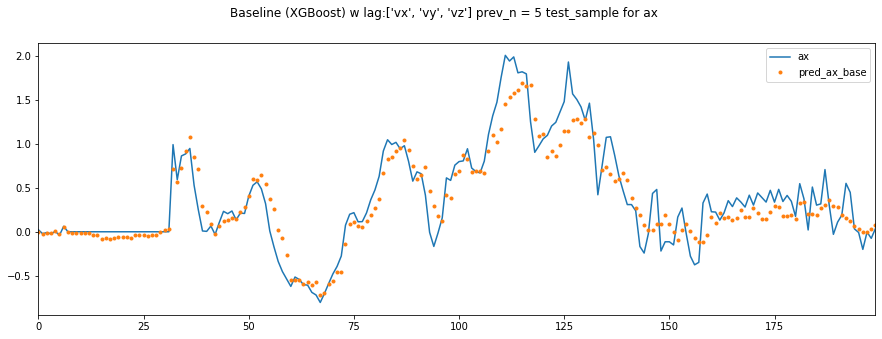

In [64]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax_base']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline (XGBoost) w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ax")

In [65]:
test['pred_ax'] = y_pred_SR

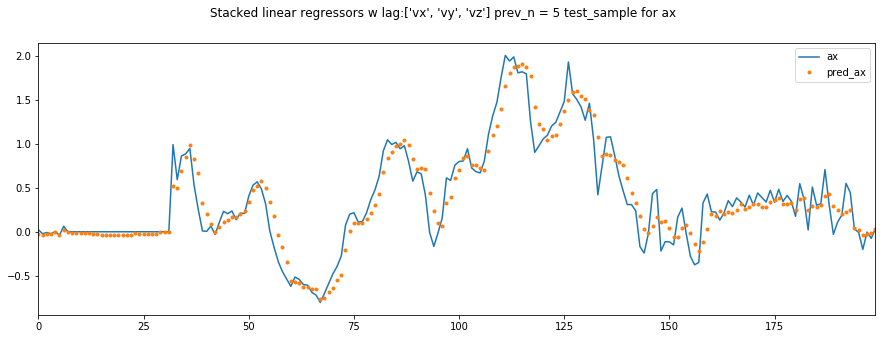

In [66]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Stacked linear regressors w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ax")

#### Ay

In [67]:
test['pred_ay_base'] = y_pred_XGB_ay

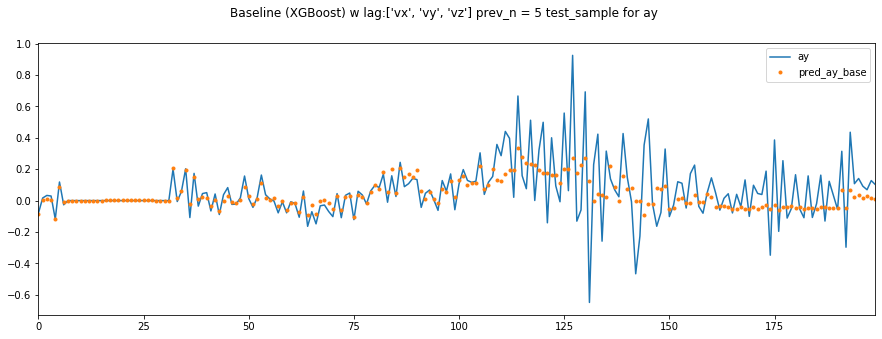

In [68]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ay', 'pred_ay_base']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline (XGBoost) w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ay")

In [69]:
test['pred_ay_base'] = y_pred_SR_ay

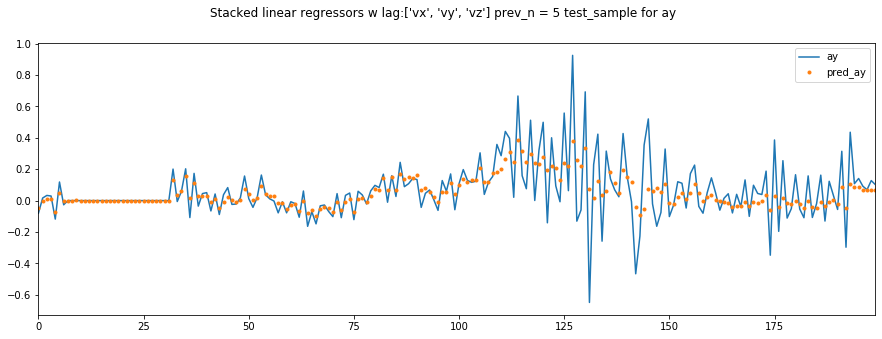

In [70]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ay', 'pred_ay']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Stacked linear regressors w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ay")

In [74]:
test_predictions = test.loc[:,['ax','pred_ax_base','pred_ax','ay','pred_ay_base','pred_ay']]

In [75]:
test_predictions.to_csv('test_predictions.csv',index = False)